In [1]:
import torch
import pandas as pd
import numpy as np
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.backends.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(f"Device: {device}")

Device: mps


In [21]:
brain = 100
x = torch.randn(1000, brain)
w = torch.randn(brain, 80000000) / brain**0.5
# y = x @ w
print(x.shape, x.mean(), x.std(), x.min(), x.max())
print(w.shape, w.mean(), w.std(), w.min(), w.max())
# print(y.shape, y.mean(), y.std(), y.min(), y.max())
# plt.figure(figsize=(10, 2))
# plt.subplot(121)
# plt.hist(x.view(-1).tolist(), 50, density=True);
# plt.subplot(122)
# plt.hist(y.view(-1).tolist(), 50, density=True);

In [3]:
import json
f = open('names.json')
names = json.load(f)

In [4]:
def atoi(a):
  return 0 if a == '.' else (ord(a) - ord('a') + 1)

def itoa(i):
  return '.' if i == 0 else (chr(i - 1 + ord('a')))

In [5]:
context_length = 3
train_x = []
train_y = []
for name in names:
  name = f"{'.' * context_length}{name.lower()}."
  samples = [name[idx-(context_length + 1):idx] for idx in range(context_length + 1, len(name) + 1)]
  train_x.extend([[atoi(x) for x in sample[0:-1]] for sample in samples])
  train_y.extend([atoi(sample[-1]) for sample in samples])

train_x = torch.tensor(train_x, device=device)
train_y = torch.nn.functional.one_hot(torch.tensor(train_y, device=device), num_classes=27).float().to(device)
print(train_x.shape, train_y.shape)

torch.Size([34894, 3]) torch.Size([34894, 27])


In [52]:
embedding_dims = 32
brain_capacity = 512
output_dim = 27

C = (torch.randn((27, embedding_dims))).to(device)
W1 = (torch.randn((embedding_dims * context_length, brain_capacity)) * (5./3.) / ((embedding_dims * context_length)**0.5)).to(device)
b1 = (torch.randn(brain_capacity) * 0.).to(device)
W2 = (torch.randn((brain_capacity, output_dim)) / (brain_capacity)**0.5).to(device)
b2 = (torch.randn(output_dim) * 0.).to(device)
bn_gain = (torch.ones(1, brain_capacity)).to(device)
bn_bias = (torch.zeros(1, brain_capacity)).to(device)

parms = [C, W1, b1, W2, b2, bn_gain, bn_bias]
parameter_count = 0
for parm in parms:
  parm.requires_grad = True
  parameter_count += parm.nelement()
print(f'{parameter_count} parameters to train')

def run_forward(x):
  emb = C[x].view(-1, embedding_dims * context_length)
  layer1 = (emb @ W1 + b1)
  layer1 = bn_gain * (layer1 - layer1.mean(0, keepdim=True)) / layer1.std(0, keepdim=True) + bn_bias
  print(layer1.mean(), layer1.std())
  layer2 = (layer1.tanh() @ W2 + b2) # softmax when executing, cross_entropy for loss
  return layer2

65403 parameters to train


In [54]:
run_forward(train_x[:10]);

tensor(-2.2352e-09, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.9488, device='mps:0', grad_fn=<StdBackward0>)


In [55]:
losses = []
batch_size = 1024

epoch_count = 1000
lr_exp = torch.linspace(0, -4, epoch_count)

for epoch in range(epoch_count):
  for i in range(train_x.shape[0] // batch_size):
    logits = run_forward(train_x[i*batch_size:(i+1)*batch_size])
    output = train_y[i*batch_size:(i+1)*batch_size]
    loss = torch.nn.functional.cross_entropy(logits, output)
    if i % 23 == 0:
      losses.append(loss.cpu().data)
    for parm in parms:
      parm.grad = None
    loss.backward()
    for parm in parms:
      parm.data -= 10**lr_exp[epoch] * parm.grad
  if epoch % 100 == 0:
    print(f"Epoch {epoch}, loss is around {losses[-1]}")

x = np.arange(len(losses))
fx = np.array(losses)
source = pd.DataFrame({
  'x': x,
  'f(x)': fx
})

alt.Chart(source).mark_line().encode(
    x='x',
    y='f(x)'
)

tensor(-9.3132e-10, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.9995, device='mps:0', grad_fn=<StdBackward0>)
tensor(-0.0002, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.9992, device='mps:0', grad_fn=<StdBackward0>)
tensor(-0.0005, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.9974, device='mps:0', grad_fn=<StdBackward0>)
tensor(-0.0008, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.9956, device='mps:0', grad_fn=<StdBackward0>)
tensor(-0.0007, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.9929, device='mps:0', grad_fn=<StdBackward0>)
tensor(-0.0004, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.9891, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0007, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.9859, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0013, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.9816, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0010, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.9786, device='mps:0', grad_fn=<StdBac

KeyboardInterrupt: 

In [134]:
import altair as alt
import pandas as pd

chars = list(".abcdefghijklmnopqrstuvwxyz")
char_type = ['start' if char == '.' else ('vowel' if char in "aeiouy" else 'consonant') for char in chars]
xy = C[[atoi(char) for char in chars]].cpu().T.data
data = pd.DataFrame({'char': chars,
                     'type': char_type,
                     'x': xy[0],
                     'y': xy[1],
                    })
alt.Chart(data).mark_text(align='center',
    baseline='middle',
    dx=0,
    dy=0,
    fontSize=14,
    fontWeight=600).encode(text='char', x='x', y='y', color='type')

alt.Chart(...)

In [35]:
out_names = []
while len(out_names) < 16:
  current_name = "..."
  while True:
    next_probs = run_forward(torch.tensor([atoi(char) for char in current_name[-context_length:]], device=device))
    next_probs = next_probs.softmax(1).view(-1)
    char = itoa(torch.multinomial(next_probs, num_samples=1, replacement=True))
    if char == '.':
      out_name = ''.join(current_name[context_length:]).capitalize()
      # Only accept names that aren't in the training set
      if out_name not in names:
        out_names.append(out_name)
      else:
        print("Seen!")
      break
    current_name += char
  
for out_name in out_names:
  print(out_name)

tensor([9.4251e-03, 2.7151e-06, 3.6610e-10, 3.5315e-07, 2.0626e-09, 9.8962e-01,
        2.2454e-11, 2.3856e-08, 6.7105e-05, 1.2344e-05, 1.2882e-07, 3.2974e-06,
        6.9549e-09, 3.5916e-08, 6.5961e-10, 3.9841e-10, 1.8546e-08, 5.1422e-10,
        6.5003e-11, 1.4163e-13, 1.1307e-10, 1.0789e-09, 6.5821e-06, 3.1063e-08,
        2.5918e-11, 8.6439e-04, 9.5354e-08], device='mps:0',
       grad_fn=<ViewBackward0>)
tensor([9.4251e-03, 2.7151e-06, 3.6610e-10, 3.5315e-07, 2.0626e-09, 9.8962e-01,
        2.2454e-11, 2.3856e-08, 6.7105e-05, 1.2344e-05, 1.2882e-07, 3.2974e-06,
        6.9549e-09, 3.5916e-08, 6.5961e-10, 3.9841e-10, 1.8546e-08, 5.1422e-10,
        6.5003e-11, 1.4163e-13, 1.1307e-10, 1.0789e-09, 6.5821e-06, 3.1063e-08,
        2.5918e-11, 8.6439e-04, 9.5354e-08], device='mps:0',
       grad_fn=<ViewBackward0>)
tensor([9.4251e-03, 2.7151e-06, 3.6610e-10, 3.5315e-07, 2.0626e-09, 9.8962e-01,
        2.2454e-11, 2.3856e-08, 6.7105e-05, 1.2344e-05, 1.2882e-07, 3.2974e-06,
        6.9549

torch.Size([256, 96]) torch.Size([96, 512])
torch.Size([131072])
tensor(0.0008) tensor(1.0030) tensor(-3.6017) tensor(4.3972)
tensor(-0.0040) tensor(2.7927) tensor(-7.3263) tensor(8.5764)
torch.Size([256, 512])


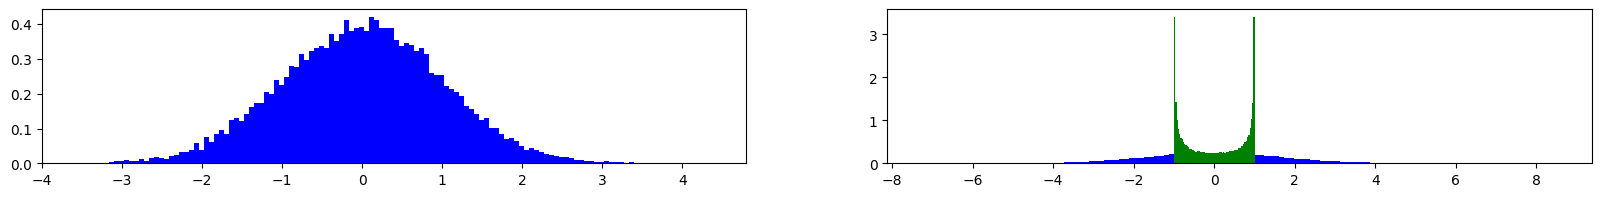

In [17]:
with torch.no_grad():
    emb = torch.randn((256, train_x.shape[1] * embedding_dims), device=device)# C[train_x[:]].view(-1, embedding_dims * context_length)
    print(emb.shape, W1.shape)
    layer1 = (emb @ W1 + b1)
    layer2 = (layer1.tanh() @ W2 + b2)
    emb_x = layer1.view(-1).cpu().data
    print(emb_x.shape)
    print(emb.cpu().data.mean(), emb.cpu().data.var(), emb.cpu().data.min(), emb.cpu().data.max())
    print(emb_x.mean(), emb_x.var(), emb_x.min(), emb_x.max())
    print(layer1.shape)
    # plt.figure(figsize=(20, 10))
    # plt.imshow(layer1.T.abs().cpu() > 0.99, cmap="gray", interpolation="nearest")
    plt.figure(figsize=(20, 2))
    plt.subplot(121)
    plt.hist(emb.view(-1).tolist(), color="blue", bins=128, density=True);
    plt.subplot(122)
    plt.hist(layer1.view(-1).tolist(), color="blue", bins=128, density=True);
    plt.hist(layer1.tanh().view(-1).tolist(), color="green", bins=64, density=True);